[EMアルゴリズム徹底解説 \- Qiita](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)

[Qiita\_Contents/Gaussian\_mixture\_demo\-automate\-animate\.ipynb at master · matsuken92/Qiita\_Contents](https://github.com/matsuken92/Qiita_Contents/blob/master/EM_Algorithm/Gaussian_mixture_demo-automate-animate.ipynb)

In [2]:
import numpy
import scipy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
import seaborn
seaborn.set_style("whitegrid", {'grid.linestyle': '--'})

## create data

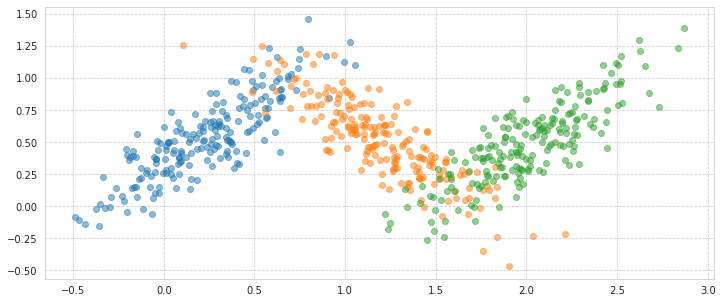

In [3]:
mu_true = numpy.array(
    [
        [0.2, 0.5],
        [1.2, 0.5],
        [2.0, 0.5],
    ]
)
sigma_true = numpy.array(
    [
        [[0.1, 0.085], [0.085, 0.1],],
        [[0.1, -0.085], [-0.085, 0.1],],
        [[0.1, 0.085], [0.085, 0.1],],
    ]
)

org_data = [
    scipy.stats.multivariate_normal.rvs(mean=mu, cov=sigma, size=200) for mu, sigma in zip(mu_true, sigma_true)
]

plt.figure(figsize=(12, 5))
for d in org_data:
    plt.scatter(x=d[:, 0], y=d[:, 1], alpha=0.5)

# Initialize

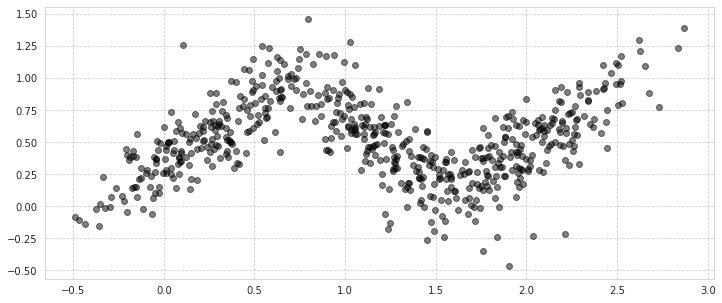

In [4]:
data = numpy.concatenate(org_data)

plt.figure(figsize=(12, 5))
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.5, c='black')

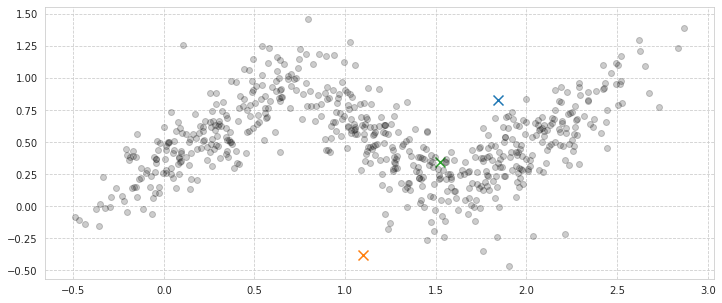

In [5]:
NUMBER_OF_CLUSTERS = 3

pi = numpy.ones(NUMBER_OF_CLUSTERS)/NUMBER_OF_CLUSTERS

mu = numpy.random.uniform(low=data.min(axis=0), high=data.max(axis=0), size=(NUMBER_OF_CLUSTERS, data.shape[1]))

sigma = numpy.array([
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
])

plt.figure(figsize=(12, 5))
for m in mu:
    plt.scatter(x=m[0], y=m[1], marker='x', s=100)
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.2, c='black')

# EM algorithm
- $n$: number of data
- $k$: number of clusters
- $z_{nk}$: latent variable where the datum belongs
- $\gamma(z_{nk})$: responsibility
- 
## E-step


In [10]:
import numpy.typing
import dataclasses
@dataclasses.dataclass
class EM_Algorithm:
    NUMBER_OF_CLUSTERS: int
    mu: numpy.typing.ArrayLike
    sigma: numpy.typing.ArrayLike

    def __post_init__(self):
        assert self.NUMBER_OF_CLUSTERS is not None

        assert self.mu.shape[0] == self.NUMBER_OF_CLUSTERS

        assert self.sigma.shape[0] == self.NUMBER_OF_CLUSTERS
        assert self.sigma.shape[1:] == (self.mu.shape[1], self.mu.shape[1])

        self.pi = numpy.ones(self.NUMBER_OF_CLUSTERS)/self.NUMBER_OF_CLUSTERS
        

    def likelihood(self, data):
        """return likelihood as a (N_of_Clusters, data_length)-shape array
        """
        return numpy.stack(
            [p * scipy.stats.multivariate_normal.pdf(data, m, s) for p, m, s in zip(self.pi, self.mu, self.sigma)]
        ).T

    def e_step(self, data):
        e_likelihood = self.likelihood(data)
        self.gamma = e_likelihood / e_likelihood.sum(axis=0)
        return self.gamma
    
    def m_step(self, data):
        self.pi = self.gamma.sum(axis=1) / len(data)

        self.sigma = self.gamma.dot(
            numpy.stack(
                [(data-m).dot((data-m).T) for m in self.mu]
            )
        ).sum(axis=1) / self.gamma.sum(axis=1)

        self.mu = self.g.dot(data) / self.gamma.sum(axis=1)


In [ ]:
em = EM_Algorithm(NUMBER_OF_CLUSTERS, mu, sigma)
prev_likelihood = numpy.log(em.likelihood(data)).sum()

for i in range(20):
    _ = em.e_step(data)
    _ = em.m_step(data)

    # 

    # check convergence
    likelihood = numpy.log(em.likelihood(data)).sum()
    if prev_likelihood - likelihood > 1e-4:
        break
